<a href="https://colab.research.google.com/github/sarthag/CIFAR10/blob/main/CIFAR10_resnet3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/CIFAR10') 

Mounted at /content/gdrive


In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import time

In [5]:
in_channel = 3
num_classes = 10
batch_size = 400
epochs = 40
learning_rate = 0.01

In [6]:
cifar_10 = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transforms.ToTensor())

images = torch.stack([image for image,label in cifar_10],dim= 3)
images.shape

means = images.view(3,-1).mean(dim = 1)
stds = images.view(3,-1).std(dim = 1)
print(means, stds)


Extracting ./data/cifar-10-python.tar.gz to ./data
tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [7]:
#channel wise normalization
#randomized data augmantation
train_transforms = transforms.Compose([transforms.RandomCrop(32, padding=4, padding_mode="reflect"), #Reflect padding reflects pixels and adds padding
                                       transforms.RandomHorizontalFlip(), #Randomly flips horzontally with 50% probability
                                       # transforms.RandomRotate()
                                       # transforms.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(means, stds)
                                      ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(means, stds)
                                      ])

In [8]:
train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = train_transforms)
test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = test_transforms)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def denormalize(images, means, stds):
  means = torch.tensor(means).reshape(1,3,1,1)
  stds = torch.tensor(stds).reshape(1,3,1,1)
  return images*stds + means

In [10]:
def show_batch(dataloader):
  for images, labels in dataloader:
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_imgs = denormalize(images, means, stds)
    ax.imshow(make_grid(denorm_imgs[:64], nrow = 8).permute(1,2,0).clamp(0,1))
    break

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


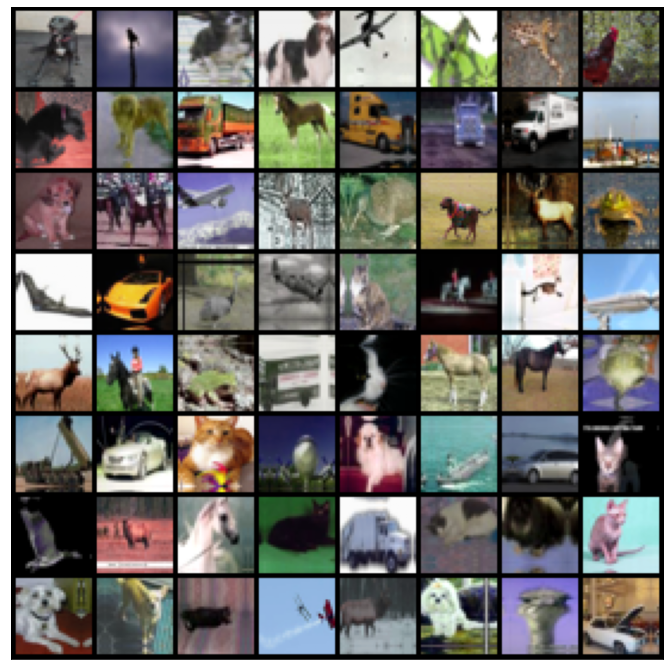

In [11]:
show_batch(train_loader)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [13]:
def check_accuracy(loader, model):
    
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
          x = x.to(device = device)
          y = y.to(device = device)
          scores = model(x)
          predictions = scores.argmax(1)
          num_correct += sum((predictions == y))
          num_samples += predictions.size(0)
            
    return float(num_correct)/float(num_samples)

In [14]:
def basic_test(architecture):
    model = architecture()
    model = model.to(device = device)
    x = torch.randn(batch_size,3,32,32)
    x = x.to(device = device)
    start = time.process_time()
    print(model(x).shape)
    end = time.process_time()
    print("time: ", end-start)

In [15]:
def model_train(model):
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    model = model.to(device = device)
    history = {"train_accs": [], "val_accs": [], "losses":[], "lrs": []}

    optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00025, max_lr=0.01,cycle_momentum=False, step_size_up=5, mode="triangular2")
    skips = [i for i in range(10, epochs ,10)]
    loss_fun = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        start = time.process_time()
        model.train()
        loss_train = 0
        for batch, (data,targets) in enumerate(train_loader):
            data = data.to(device = device)
            targets = targets.to(device= device)
            
            #fw_prop
            scores = model(data)
            loss = loss_fun(scores, targets)

            #bw_prop
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
            loss_train += loss.item()

            #Optimizer
            optimizer.step()
            
            
        history["lrs"].append(optimizer.param_groups[0]["lr"])
        
        scheduler.step()
        if epoch in skips:
          for j in range(10):
            scheduler.step()

        history["train_accs"].append(check_accuracy(train_loader, model))
        history["val_accs"].append(check_accuracy(test_loader, model))
        history["losses"].append(loss_train/(len(train_loader)))
        
        end = time.process_time()
        exec_time = end-start

        print('Epoch ({}/{}),Training loss : {:.4f}, Time: {:.2f},Last lr: {:.5f} train_accuracy:{:.4f}, val_accuracy:{:.4f}'.format(
              epoch+1, epochs, history["losses"][-1], exec_time, history["lrs"][-1], history["train_accs"][-1], history["val_accs"][-1]))

    return model, history

In [16]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias = False), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    
    if pool: layers.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*layers)



class Resnet_arch1(nn.Module):
  def __init__(self, in_channels = 3, num_classes = 10):
    super(Resnet_arch1, self).__init__()
    self.conv1 = conv_block(in_channels, 32) 
    self.conv2 = conv_block(32, 64, pool = True) 
    self.res1 = nn.Sequential(conv_block(64,64), 
                               conv_block(64,64))
    self.conv3 = conv_block(64, 128, pool = True) 
    self.conv4 = conv_block(128, 256, pool = True) 
    self.res2 = nn.Sequential(conv_block(256,256),
                               conv_block(256,256))
    
    self.final_pool = nn.MaxPool2d(4)
    self.dropout = nn.Dropout(0.2)
    self.output = nn.Linear(256, num_classes)
    

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.res1(x) + x
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.res2(x) + x
    x = self.final_pool(x)
    x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
    x = self.dropout(x)
    x = self.output(x)
    return x

In [17]:
basic_test(Resnet_arch1)

torch.Size([400, 10])
time:  0.06676467799999841


In [18]:
t1 = time.process_time()
model = Resnet_arch1()
model, history = model_train(model)
t2 = time.process_time()
print("Total time: ", t2-t1)

Epoch (1/40),Training loss : 1.6431, Time: 167.28,Last lr: 0.00025 train_accuracy:0.5494, val_accuracy:0.5844
Epoch (2/40),Training loss : 1.1946, Time: 167.89,Last lr: 0.00220 train_accuracy:0.6892, val_accuracy:0.7018
Epoch (3/40),Training loss : 0.9236, Time: 168.98,Last lr: 0.00415 train_accuracy:0.6657, val_accuracy:0.6647
Epoch (4/40),Training loss : 0.8004, Time: 169.84,Last lr: 0.00610 train_accuracy:0.6596, val_accuracy:0.6685
Epoch (5/40),Training loss : 0.7236, Time: 169.94,Last lr: 0.00805 train_accuracy:0.7564, val_accuracy:0.7640
Epoch (6/40),Training loss : 0.6531, Time: 168.44,Last lr: 0.01000 train_accuracy:0.7455, val_accuracy:0.7568
Epoch (7/40),Training loss : 0.5318, Time: 168.54,Last lr: 0.00805 train_accuracy:0.7864, val_accuracy:0.7790
Epoch (8/40),Training loss : 0.4351, Time: 166.53,Last lr: 0.00610 train_accuracy:0.8353, val_accuracy:0.8296
Epoch (9/40),Training loss : 0.3540, Time: 165.67,Last lr: 0.00415 train_accuracy:0.8690, val_accuracy:0.8566
Epoch (10/

In [19]:
print("final_train_accuracy: ", history["val_accs"][-1]) 

final_train_accuracy:  0.9151


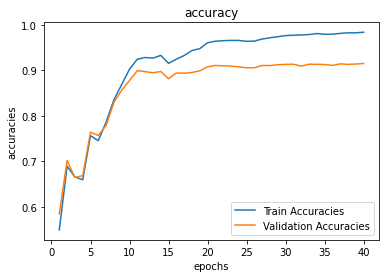

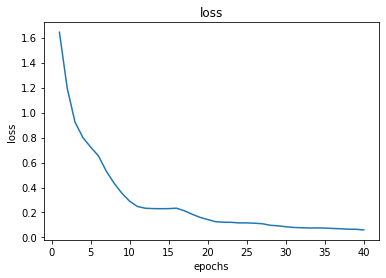

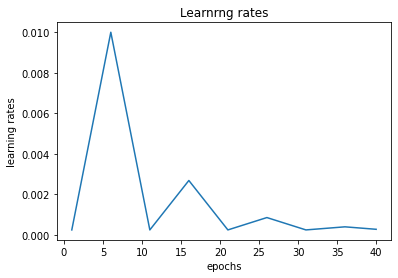

In [20]:
epochs_range = [i+1 for i in range(epochs)]
plot1 = plt.figure(1)
plt.plot(epochs_range,history["train_accs"], label = 'Train Accuracies')
plt.plot(epochs_range,history["val_accs"], label = 'Validation Accuracies')
plt.xlabel("epochs")
plt.ylabel("accuracies")
plt.title('accuracy')
plt.legend()

plot2 = plt.figure(2)
plt.plot(epochs_range,history["losses"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('loss')
plt.show()

plot2 = plt.figure(3)
plt.plot(epochs_range,history["lrs"])
plt.xlabel("epochs")
plt.ylabel("learning rates")
plt.title('Learnrng rates')
plt.show()